In [671]:
from __future__ import print_function, division
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler
from torchvision import transforms, utils, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
from typing import Dict
import random
# Soravit Wetprasit 2514982W

In [672]:
# Custom data loader for training dataset which stored image, image number, celltype and class number.
class CCTrainDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        
        self.info = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.all_imgs = os.listdir(root_dir)
        
    def __len__(self):
        #return len(self.all_img)
        return len([img for img in self.all_imgs])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_loc = os.path.join(self.root_dir, str(self.info.iloc[idx, 0])+'.png')
        image = io.imread(img_loc)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torchvision.transforms.functional.to_tensor(image)

        celltype = self.info.iloc[idx, 1]        
        if(celltype == 'Cancer'):
            class_no = 0
        elif(celltype == 'Connective'):
            class_no = 1
        elif(celltype == 'Immune'):
            class_no = 2
        elif(celltype == 'Normal'):
            class_no = 3
        
        sample = {'image': image, 'celltype': celltype, 'loc': self.info.iloc[idx, 0], 'class': class_no}

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample

In [673]:
# Load train dataset from train.csv with folder directory
my_train_dataset = CCTrainDataset(csv_file='train.csv', root_dir='train/train/')

# Reshape and Stack all image from train dataset to compute mean and standard deviation
imgs_stack = torch.stack([img_s['image'] for img_s in my_train_dataset], dim=3)
temp_imgs = imgs_stack.view(3, -1)
imgs_mean = temp_imgs.mean(dim=1)
imgs_std = temp_imgs.std(dim=1)

In [674]:
# Load train dataset again but with transform normalize function of means and standard deviation
norm_train_dataset = CCTrainDataset(csv_file='train.csv', 
                                    root_dir='train/train/', 
                                    transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(imgs_mean.numpy(), imgs_std.numpy())]))

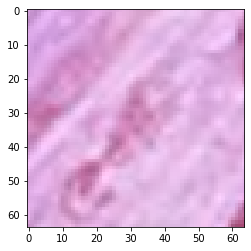

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


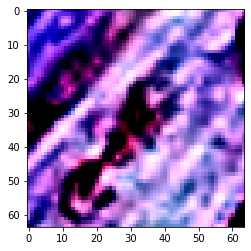

In [675]:
# Compare between image and normalize image datasets
it = 0
for img_s in my_train_dataset:
    it += 1
    if (it == 10):
        plt.imshow(img_s['image'].permute(1, 2, 0))
        plt.show()
        #print(img_s['image'])
nt = 0
for img_s in norm_train_dataset:
    nt += 1
    if (nt== 10):
        plt.imshow(img_s['image'].permute(1, 2, 0))
        plt.show()
        #print(img_s['image'])

In [676]:
# Function use for counting class(celltype) distribution and return total number of each class
def get_class_distribution(input_dataset):
    
    idx_data_list = [data['celltype'] for data in input_dataset]
    classes, count = np.unique(idx_data_list, return_counts=True)

    dict_class = {}
    for i in range(len(classes)):
        dict_class[classes[i]] = count[i]

    return dict_class

# Check distribution of dataset show imbalance dataset
print(get_class_distribution(my_train_dataset))

{'Cancer': 546, 'Connective': 726, 'Immune': 729, 'Normal': 189}


In [677]:
# Set seed number to generate same result when random sampling
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# sampler function using Weighted Random Sampler for balancing distribution of data by random sampling
def sampler_(labels):
    idx_data_list = [data['celltype'] for data in labels]
    idx_type = []
    for data in labels:
        if(data['celltype'] == 'Cancer'):
            idx_type.append(0)
        elif(data['celltype'] == 'Connective'):
            idx_type.append(1)
        elif(data['celltype'] == 'Immune'):
            idx_type.append(2)
        elif(data['celltype'] == 'Normal'):
            idx_type.append(3)

        set_seed(321)        

    array_idx_type = np.asarray(idx_type)
    _, counts = np.unique(idx_data_list, return_counts=True)
    
    # Compute weight for each celltype(class) from current distribution then apply to function
    weights = 1.0 / torch.tensor(counts, dtype=torch.float)
    sample_weights = weights[array_idx_type]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [678]:
# Input normalize train dataset to sampler function 
norm_sampler = sampler_(norm_train_dataset)
weighted_loader = DataLoader(norm_train_dataset, batch_size=50, sampler=norm_sampler, drop_last=True)

In [679]:
# Old code in checking class distribution before create new function
aroi = [0,0,0,0]
for batch_idx, (data) in enumerate(weighted_loader):
    #print('Batch {}, classes {}, count {}'.format(batch_idx, *np.unique(data['celltype'], return_counts=True)))
    aroi += np.unique(data['celltype'], return_counts=True)[1]
    #print(data['loc'])\n",
    #print(aroi)\n",

get_class_distribution(weighted_loader)

{'Cancer': 515, 'Connective': 561, 'Immune': 543, 'Normal': 531}

In [700]:
# Split data into train and validation set 80:20
norm_dataset_size = len(norm_sampler)
norm_sampler_indices = list(norm_sampler)
val_split_index = int(np.floor(0.2 * norm_dataset_size))
train_idx, val_idx = norm_sampler_indices[val_split_index:],norm_sampler_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [701]:
# Using DataLoader loading the normalize dataset with 50 batch for both train and validation set
train_loader = DataLoader(norm_train_dataset, batch_size=50, shuffle=False, sampler=train_sampler, drop_last=True)
val_loader = DataLoader(norm_train_dataset, batch_size=50, shuffle=False, sampler=val_sampler, drop_last=True)

# Check class distribution 
print(get_class_distribution(train_loader))
print(get_class_distribution(val_loader))

{'Cancer': 438, 'Connective': 430, 'Immune': 476, 'Normal': 406}
{'Cancer': 88, 'Connective': 97, 'Immune': 103, 'Normal': 112}


In [706]:
# Set convolution neural network model with 2Conv with maxpooling and 3Linear
model = nn.Sequential(collections.OrderedDict([
          
          ('conv1', nn.Conv2d(3, 64, kernel_size=3, padding=1)),
          ('relu1', nn.ReLU()),
          ('maxpool', nn.MaxPool2d(kernel_size=3, stride=3)),

          ('conv2', nn.Conv2d(64, 64, kernel_size=3, padding=1)),
          ('relu2', nn.ReLU()),
          ('maxpool2', nn.MaxPool2d(kernel_size=2, stride=2)),
    
          ('flatD', nn.Flatten()),
          ('ln1', nn.Linear(6400, 2400)),
          ('relun1', nn.ReLU()),

          ('ln2', nn.Linear(2400, 600)),
          ('relun2', nn.ReLU()),

          ('ln3', nn.Linear(600, 4)),
          ('relun3', nn.ReLU()),
        ]))

In [707]:
print(model)

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatD): Flatten(start_dim=1, end_dim=-1)
  (ln1): Linear(in_features=6400, out_features=2400, bias=True)
  (relun1): ReLU()
  (ln2): Linear(in_features=2400, out_features=600, bias=True)
  (relun2): ReLU()
  (ln3): Linear(in_features=600, out_features=4, bias=True)
  (relun3): ReLU()
)


In [704]:
# Set device and dtype
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
dtype = torch.float

In [705]:
# Training loop of model with reurn number of total loss in each epoch
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for data in train_loader:
            imgs = data['image']
            labels = data['class']
            
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            loss_list.append(loss_train)
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
    return loss_list

In [686]:
# Set parameter of optimizer and number of epochs
lr = 0.001
momentum = 0.9
weight_decay = 0.001
n_epochs = 20

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

# Call training loop to train network with above optimizer and cross entropy loss function
loss_list = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-05-23 22:25:29.713198 Epoch 1, Training loss 48.38410723209381
2021-05-23 22:25:40.376250 Epoch 2, Training loss 47.744860768318176
2021-05-23 22:25:51.236937 Epoch 3, Training loss 46.65079617500305
2021-05-23 22:26:02.203662 Epoch 4, Training loss 44.632604122161865
2021-05-23 22:26:13.095269 Epoch 5, Training loss 41.07089352607727
2021-05-23 22:26:23.968193 Epoch 6, Training loss 36.10877996683121
2021-05-23 22:26:34.880541 Epoch 7, Training loss 32.32303577661514
2021-05-23 22:26:45.887640 Epoch 8, Training loss 29.75167554616928
2021-05-23 22:26:57.271629 Epoch 9, Training loss 26.95807635784149
2021-05-23 22:27:07.897711 Epoch 10, Training loss 24.54732173681259
2021-05-23 22:27:19.188845 Epoch 11, Training loss 23.171247750520706
2021-05-23 22:27:29.999764 Epoch 12, Training loss 21.73680666089058
2021-05-23 22:27:40.986866 Epoch 13, Training loss 19.944403916597366
2021-05-23 22:27:51.993103 Epoch 14, Training loss 18.287320405244827
2021-05-23 22:28:02.638574 Epoch 15, T

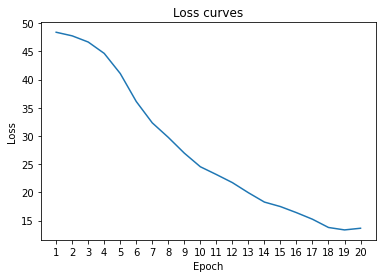

In [687]:
# Plot total training loss for each iteration
plt.plot([ep for ep in range(1,len(loss_list)+1)], np.asarray(loss_list))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.xticks(range(1,len(loss_list)+1))
plt.show()

In [688]:
# Validate function for measure accuracy of input data
def valid_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    valid_loss = 0
    correct = 0
    total_data_count = 0
    accuracy_list = []
    pred_list = []
    with torch.no_grad():
        for load in test_loader:
            imgs = load['image']
            labels = load['class']
            
            data, target = imgs.to(device), labels.to(device)
            output = model(data)
            
            valid_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            for pa in pred:        
                pred_list.append( pa.numpy())
                
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            total_data_count += len(labels)    
            
    valid_loss /= total_data_count
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, total_data_count,
        100. * correct / total_data_count))
    
    return pred_list

In [689]:
# Using validate function to check trained model of validation and training set
print('Validate set')
pred_list = valid_loop(model = model, device = device, test_loader = val_loader)
print('Train set')
acc_tra = valid_loop(model = model, device = device, test_loader = train_loader)

Validate set

Test set: Average loss: -4.6769, Accuracy: 328/400 (82%)

Train set

Test set: Average loss: -4.9668, Accuracy: 1575/1750 (90%)



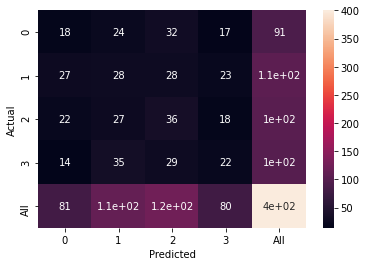

In [690]:
# Confusion matrix
import seaborn as sn

pred_array = np.asarray(pred_list).reshape(len(pred_list))

actual_list = []
for va in val_loader:
     for pa in va['class']:    
        #print(pa)
        actual_list.append(pa)
        
actual_array = np.asarray(actual_list)

act_pre = {'val_Actual': actual_array,
        'val_Predicted': pred_array }

cmdf = pd.DataFrame(act_pre, columns=['val_Actual','val_Predicted'])
confusion_matrix = pd.crosstab(cmdf['val_Actual'], cmdf['val_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [696]:
# Predict image function by using trained model 
def predict_image(image):
    data = image.to(device)
    output = model(data)
    _, predicted = torch.max(output, 1)
    index = output.data.cpu().numpy().argmax()
    return index

# Custom data loader for test dataset include image and image number data
class CCTestDataset(Dataset):
    
    def __init__(self, root_dir, transform=None, target_transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.all_imgs = os.listdir(root_dir)
        
    def __len__(self):
        return len([img for img in self.all_imgs])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        img_loc = os.path.join(self.root_dir, self.all_imgs[idx])
        image = io.imread(img_loc)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torchvision.transforms.functional.to_tensor(image)

        image_no = self.all_imgs[idx]
        image_no = image_no[:-4]
            
        sample = {'image': image, 'loc':image_no }
        
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample

In [697]:
# Load test dataset with normalize function due to model train from normalize dataset, so need to apply for test dataset
my_test_dataset_normalize = CCTestDataset(root_dir='test/test/', 
                                    transform=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(imgs_mean.numpy(), imgs_std.numpy())]))
test_loader = DataLoader(my_test_dataset_normalize)
model.eval()

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatD): Flatten(start_dim=1, end_dim=-1)
  (ln1): Linear(in_features=6400, out_features=2400, bias=True)
  (relun1): ReLU()
  (ln2): Linear(in_features=2400, out_features=600, bias=True)
  (relun2): ReLU()
  (ln3): Linear(in_features=600, out_features=4, bias=True)
  (relun3): ReLU()
)

In [698]:
# Declare panda data frame for Id and Type column then call predict function for each test image then assign result
df = pd.DataFrame(columns=['Id', 'Type'])

for datatest in test_loader:
    class_number = predict_image(datatest['image'])
    
    if(class_number == 0):
        class_type = 'Cancer'
    elif(class_number == 1):
        class_type = 'Connective'
    elif(class_number == 2):
        class_type = 'Immune'
    elif(class_number == 3):
        class_type = 'Normal'    
    
    id_pic = ''.join(datatest['loc'])
    
    df.loc[len(df)] = [id_pic, class_type]

In [694]:
# save current trained model
torch.save(model, 'ccmodel.pth')

#model = torch.load('ccmodel.pth')

In [699]:
# save dataframe to test.csv
df.to_csv('test.csv', index=False)